### Primary Objective:

#### Build a XGB machine learning model that can accurately classify sonar signals as either rocks or mines with high precision and recall, particularly minimizing false negatives (missing actual mines).

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

#### Data Loading and Initial Exploration

In [5]:
# Load the dataset
df = pd.read_csv('rock_mine_data.csv', header=None)

# Basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check target variable distribution
print("\nTarget Variable Distribution:")
print(df.iloc[:, -1].value_counts())  # Assuming last column is target

Dataset Shape: (208, 61)

First 5 rows:
       0       1       2       3       4       5       6       7       8   \
0  0.0200  0.0371  0.0428  0.0207  0.0954  0.0986  0.1539  0.1601  0.3109   
1  0.0453  0.0523  0.0843  0.0689  0.1183  0.2583  0.2156  0.3481  0.3337   
2  0.0262  0.0582  0.1099  0.1083  0.0974  0.2280  0.2431  0.3771  0.5598   
3  0.0100  0.0171  0.0623  0.0205  0.0205  0.0368  0.1098  0.1276  0.0598   
4  0.0762  0.0666  0.0481  0.0394  0.0590  0.0649  0.1209  0.2467  0.3564   

       9       10      11      12      13      14      15      16      17  \
0  0.2111  0.1609  0.1582  0.2238  0.0645  0.0660  0.2273  0.3100  0.2999   
1  0.2872  0.4918  0.6552  0.6919  0.7797  0.7464  0.9444  1.0000  0.8874   
2  0.6194  0.6333  0.7060  0.5544  0.5320  0.6479  0.6931  0.6759  0.7551   
3  0.1264  0.0881  0.1992  0.0184  0.2261  0.1729  0.2131  0.0693  0.2281   
4  0.4459  0.4152  0.3952  0.4256  0.4135  0.4528  0.5326  0.7306  0.6193   

       18      19      20      21 

#### Data Preprocessing and Feature Engineering
##### Machine learning algorithms work with numerical data, so we need to encode categorical targets

In [7]:
# Separate features and target
X = df.iloc[:, :-1]  # All columns except the last one
y = df.iloc[:, -1]   # Last column (target)

# Encode target variable if it's categorical (M/R to 1/0)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Original target values:", y.unique())
print("Encoded target values:", np.unique(y_encoded))
print("Encoding mapping:", dict(zip(le.classes_, le.transform(le.classes_))))
print(f"Final dataset shape: {df.shape}")
# Check for any remaining missing values in features
if X.isnull().sum().sum() > 0:
    print("Handling missing values...")
    X = X.fillna(X.mean())  # Fill with mean for numerical features

Original target values: ['R' 'M']
Encoded target values: [0 1]
Encoding mapping: {'M': 0, 'R': 1}
Final dataset shape: (208, 61)


#### Exploratory Data Analysis

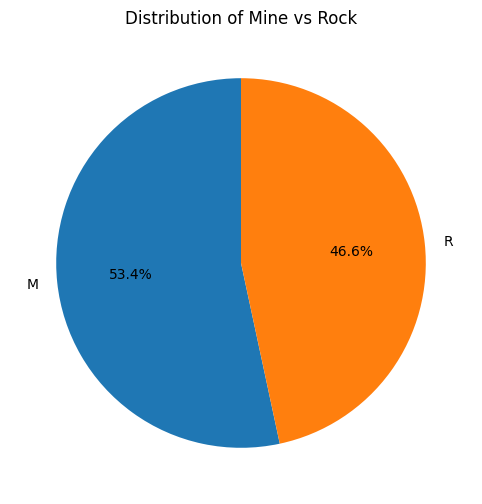

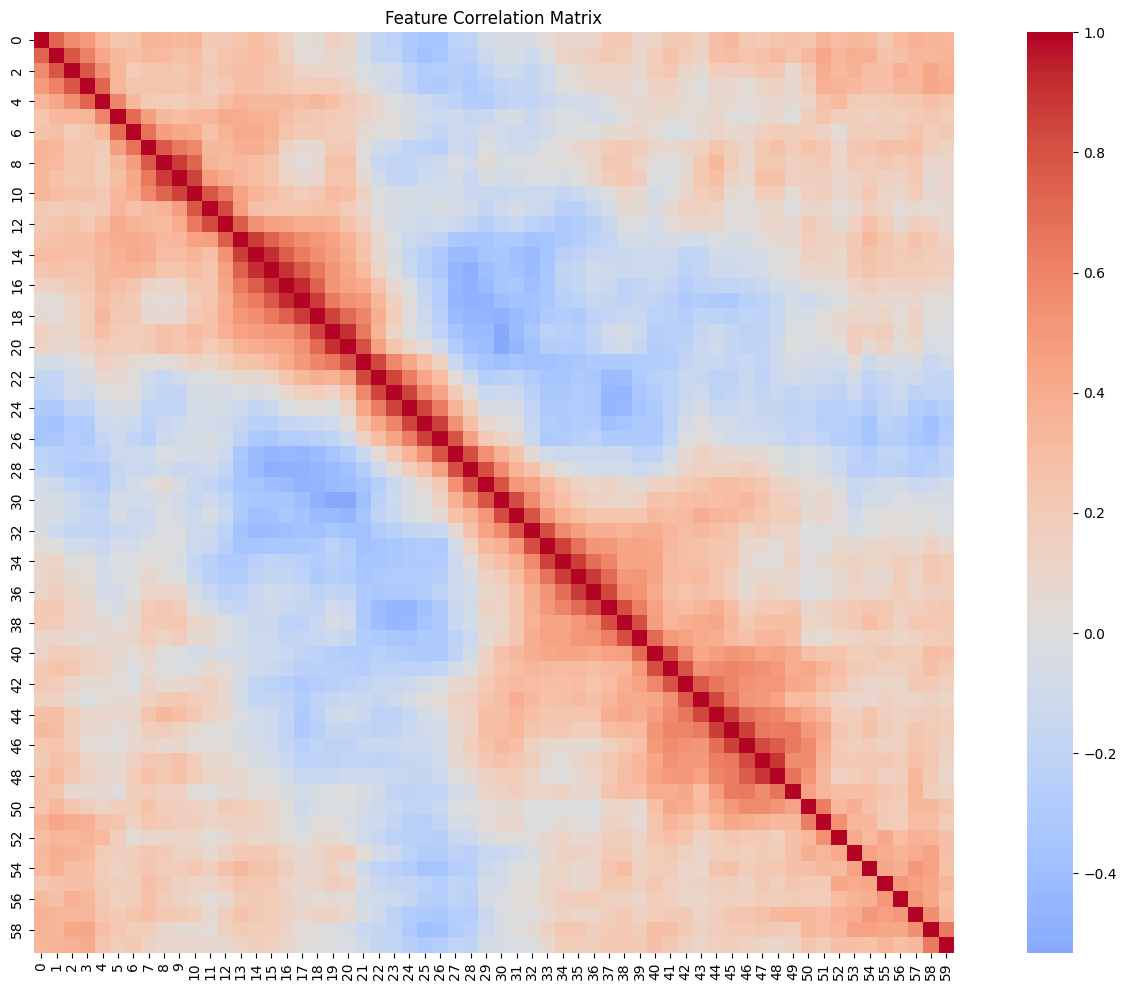

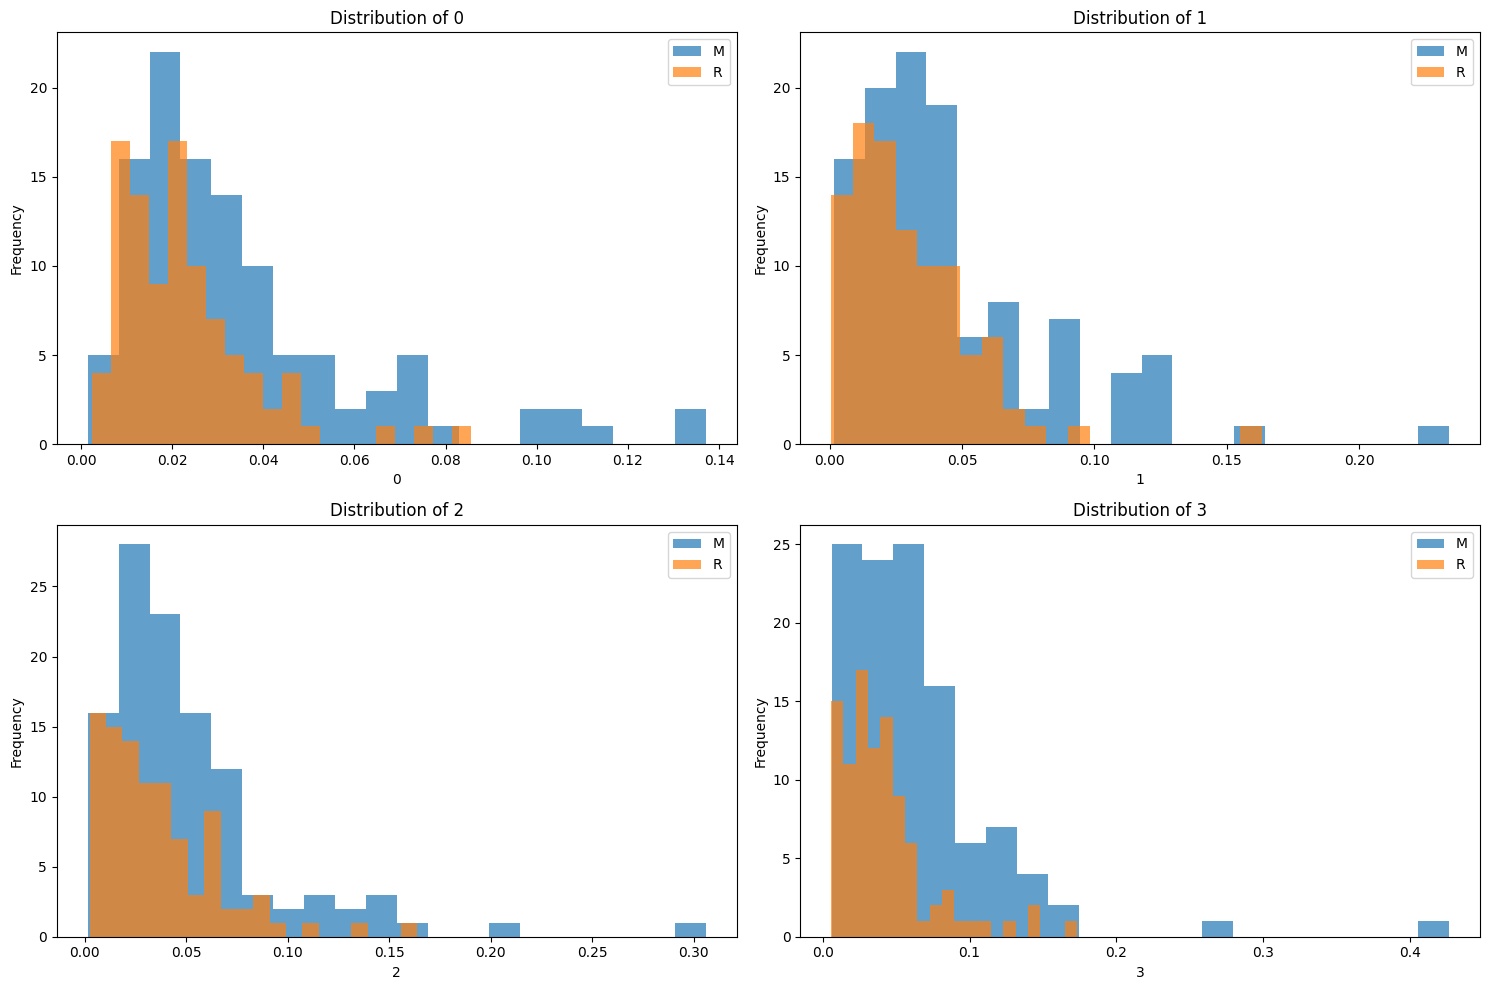


Feature Statistics by Class:

M Class Statistics:
            0        1        2        3        4        5        6        7   \
count  111.000  111.000  111.000  111.000  111.000  111.000  111.000  111.000   
mean     0.035    0.046    0.051    0.065    0.087    0.112    0.128    0.150   
std      0.027    0.038    0.044    0.054    0.060    0.053    0.058    0.087   
min      0.002    0.002    0.002    0.006    0.008    0.012    0.013    0.006   
25%      0.018    0.019    0.025    0.031    0.046    0.077    0.088    0.098   
50%      0.027    0.035    0.039    0.055    0.075    0.109    0.123    0.130   
75%      0.042    0.059    0.062    0.082    0.112    0.146    0.162    0.181   
max      0.137    0.234    0.306    0.426    0.401    0.277    0.332    0.459   

            8        9        10       11       12       13       14       15  \
count  111.000  111.000  111.000  111.000  111.000  111.000  111.000  111.000   
mean     0.213    0.251    0.290    0.301    0.314    0.3

In [8]:
# Set up the plotting style
plt.style.use('default')
fig_size = (15, 10)

# 1. Target distribution
plt.figure(figsize=(8, 6))
target_counts = pd.Series(y_encoded).value_counts()
plt.pie(target_counts.values, labels=le.classes_, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Mine vs Rock')
plt.show()

# 2. Correlation matrix
plt.figure(figsize=fig_size)
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# 3. Feature distributions by class
# Select a few features for visualization
sample_features = X.columns[:4]  # First 4 features
fig, axes = plt.subplots(2, 2, figsize=fig_size)
axes = axes.ravel()

for i, feature in enumerate(sample_features):
    for class_label in [0, 1]:
        class_data = X[y_encoded == class_label][feature]
        axes[i].hist(class_data, alpha=0.7, label=le.classes_[class_label], bins=20)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].legend()
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# 4. Statistical summary by class
print("\nFeature Statistics by Class:")
for class_idx, class_name in enumerate(le.classes_):
    print(f"\n{class_name} Class Statistics:")
    class_data = X[y_encoded == class_idx]
    print(class_data.describe().round(3))

#### Feature Scaling and Data Splitting

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling completed")
print(f"Original feature range example: {X_train.iloc[:, 0].min():.3f} to {X_train.iloc[:, 0].max():.3f}")
print(f"Scaled feature range example: {X_train_scaled[:, 0].min():.3f} to {X_train_scaled[:, 0].max():.3f}")

Training set size: (166, 60)
Test set size: (42, 60)
Training class distribution: [89 77]
Test class distribution: [22 20]

Feature scaling completed
Original feature range example: 0.003 to 0.137
Scaled feature range example: -1.210 to 4.949


#### XGBoost Model Training

In [10]:
# Create and train basic XGBoost model
xgb_basic = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss'  # Suppresses warning
)

# Train the model
xgb_basic.fit(X_train_scaled, y_train)

# Make predictions
y_pred_basic = xgb_basic.predict(X_test_scaled)
y_pred_proba_basic = xgb_basic.predict_proba(X_test_scaled)[:, 1]

# Evaluate basic model
accuracy_basic = accuracy_score(y_test, y_pred_basic)
auc_basic = roc_auc_score(y_test, y_pred_proba_basic)

print("Baseline XGBoost Model Performance:")
print(f"Accuracy: {accuracy_basic:.4f}")
print(f"AUC-ROC: {auc_basic:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_basic, target_names=le.classes_))

Baseline XGBoost Model Performance:
Accuracy: 0.9286
AUC-ROC: 0.9818

Detailed Classification Report:
              precision    recall  f1-score   support

           M       0.88      1.00      0.94        22
           R       1.00      0.85      0.92        20

    accuracy                           0.93        42
   macro avg       0.94      0.93      0.93        42
weighted avg       0.94      0.93      0.93        42



#### Hyperparameter Tuning

In [11]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Create XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

# Perform grid search with cross-validation
print("Starting hyperparameter tuning... This may take a few minutes.")
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',  # Use AUC as the metric
    n_jobs=-1,  # Use all available processors
    verbose=1
)

# Fit grid search
grid_search.fit(X_train_scaled, y_train)

# Get best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\nBest parameters: {best_params}")
print(f"Best cross-validation AUC score: {best_score:.4f}")

# Train final model with best parameters
xgb_optimized = grid_search.best_estimator_

Starting hyperparameter tuning... This may take a few minutes.
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.9}
Best cross-validation AUC score: 0.9334


#### Final Model Evaluation

Optimized XGBoost Model Performance:
Accuracy: 0.8571
AUC-ROC: 0.9795

Detailed Classification Report:
              precision    recall  f1-score   support

           M       0.81      0.95      0.88        22
           R       0.94      0.75      0.83        20

    accuracy                           0.86        42
   macro avg       0.87      0.85      0.85        42
weighted avg       0.87      0.86      0.86        42



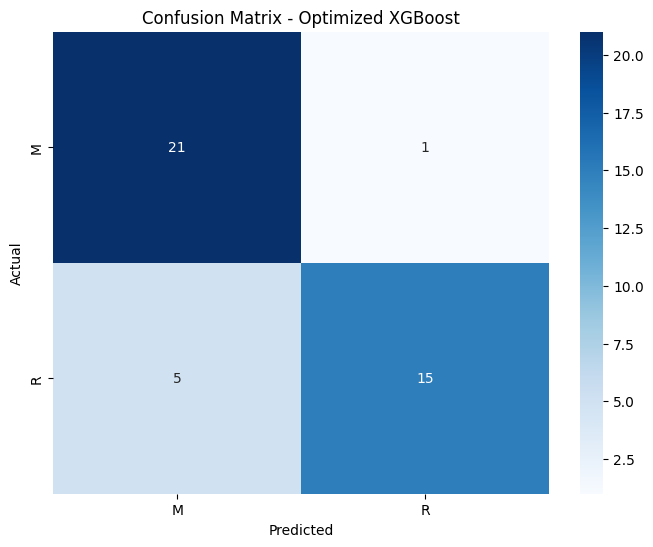

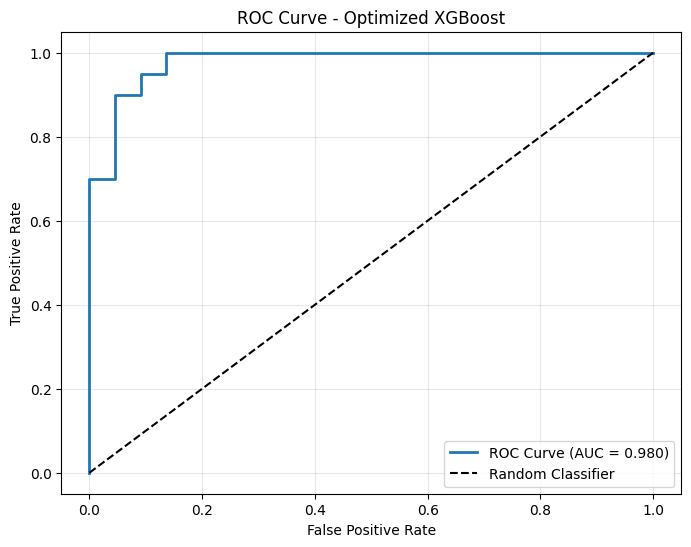

In [13]:
# Make predictions with optimized model
y_pred_optimized = xgb_optimized.predict(X_test_scaled)
y_pred_proba_optimized = xgb_optimized.predict_proba(X_test_scaled)[:, 1]

# Calculate performance metrics
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
auc_optimized = roc_auc_score(y_test, y_pred_proba_optimized)

print("Optimized XGBoost Model Performance:")
print(f"Accuracy: {accuracy_optimized:.4f}")
print(f"AUC-ROC: {auc_optimized:.4f}")
#print(f"Improvement in Accuracy: {accuracy_optimized - accuracy_basic:.4f}")
#print(f"Improvement in AUC: {auc_optimized - auc_basic:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_optimized, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Optimized XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_optimized)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_optimized:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Optimized XGBoost')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Feature Importance Analysis

Top 10 Most Important Features:
    feature  importance
19       19    0.069051
9         9    0.060142
11       11    0.054536
10       10    0.043132
1         1    0.039711
6         6    0.038014
41       41    0.036414
52       52    0.034317
46       46    0.033667
20       20    0.033266


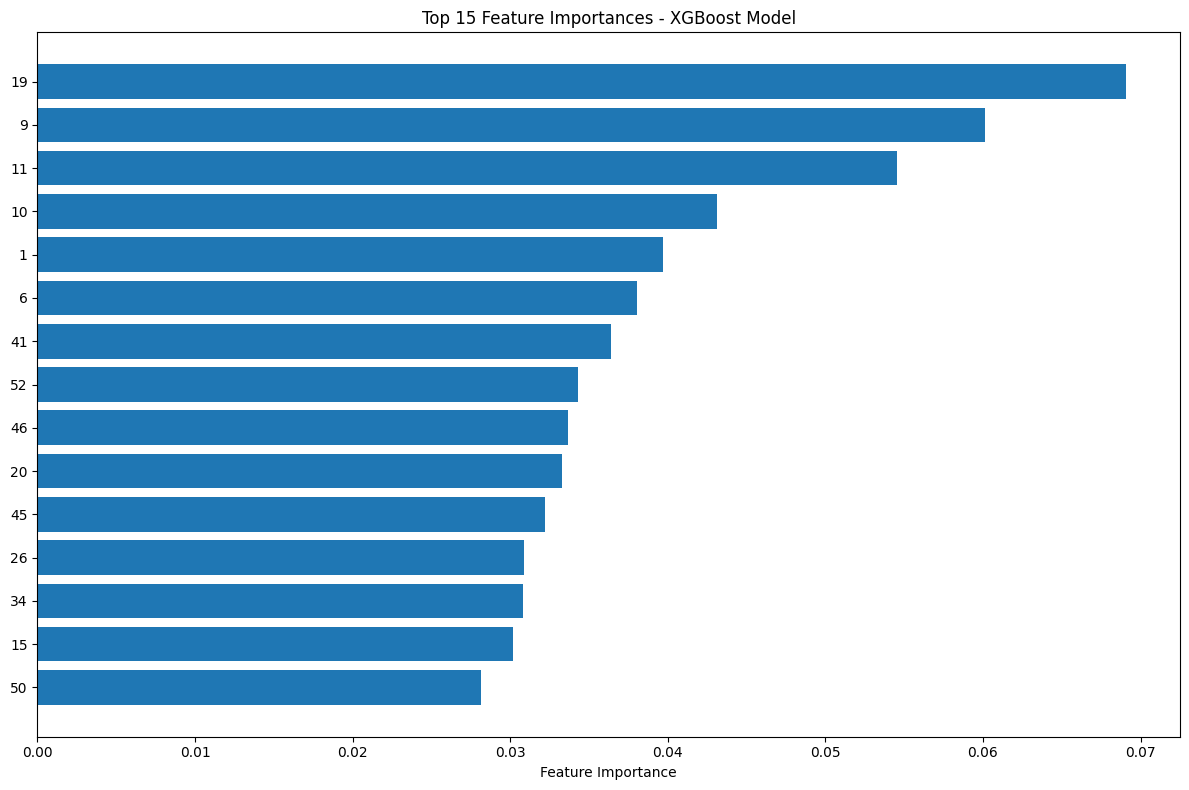

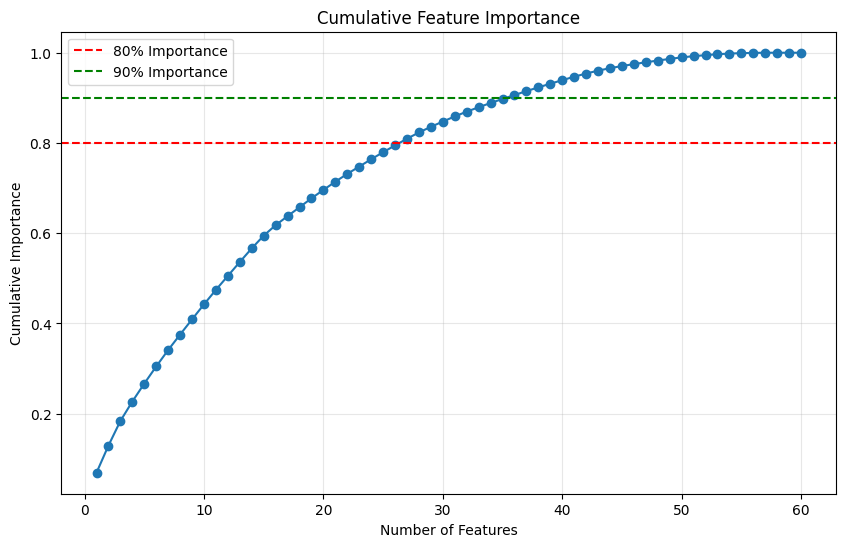


Features needed for 80% importance: 27
Features needed for 90% importance: 36


In [14]:
# Get feature importance
feature_importance = xgb_optimized.feature_importances_
feature_names = X.columns

# Create feature importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)  # Top 15 features
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances - XGBoost Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Show cumulative importance
cumulative_importance = np.cumsum(importance_df['importance'])
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Importance')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% Importance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find number of features needed for 80% and 90% importance
features_80 = np.argmax(cumulative_importance >= 0.8) + 1
features_90 = np.argmax(cumulative_importance >= 0.9) + 1
print(f"\nFeatures needed for 80% importance: {features_80}")
print(f"Features needed for 90% importance: {features_90}")

#### Cross-Validation and Model Robustness

10-Fold Cross-Validation Results:
Mean AUC: 0.9433 (+/- 0.0808)
Individual fold scores: [0.9583 0.9167 0.9028 0.9583 0.9306 0.8611 1.     1.     0.9524 0.9531]


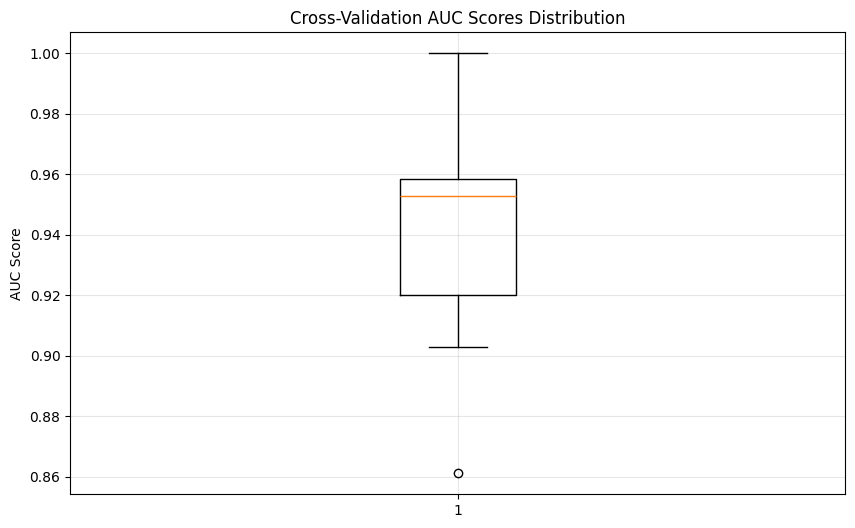

 Model shows good stability across folds (low variance)


In [16]:
# Perform k-fold cross-validation to assess model stability
cv_scores = cross_val_score(xgb_optimized, X_train_scaled, y_train, 
                           cv=10, scoring='roc_auc')

print("10-Fold Cross-Validation Results:")
print(f"Mean AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"Individual fold scores: {cv_scores.round(4)}")

# Plot cross-validation scores
plt.figure(figsize=(10, 6))
plt.boxplot(cv_scores)
plt.ylabel('AUC Score')
plt.title('Cross-Validation AUC Scores Distribution')
plt.grid(True, alpha=0.3)
plt.show()

# Verify model stability
if cv_scores.std() < 0.05:
    print(" Model shows good stability across folds (low variance)")
else:
    print(" Model shows high variance across folds - consider more regularization")

#### Model Persistence and Deployment Preparation

In [19]:
import joblib

# Save the trained model and preprocessing objects
joblib.dump(xgb_optimized, 'xgboost_mine_rock_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')

print("Model and preprocessing objects saved successfully!")

# Create a prediction function for new data
def predict_mine_or_rock(new_data, model_path='xgboost_mine_rock_model.pkl', 
                        scaler_path='feature_scaler.pkl', 
                        encoder_path='label_encoder.pkl'):
    """
    Function to make predictions on new sonar data
    
    Parameters:
    new_data: numpy array or pandas DataFrame with same features as training data
    """
    # Load saved objects
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    label_encoder = joblib.load(encoder_path)
    
    # Preprocess the data
    new_data_scaled = scaler.transform(new_data)
    
    # Make predictions
    predictions = model.predict(new_data_scaled)
    probabilities = model.predict_proba(new_data_scaled)
    
    # Convert predictions back to original labels
    predicted_labels = label_encoder.inverse_transform(predictions)
    
    return predicted_labels, probabilities

# Test the prediction function with a sample
sample_data = X_test.iloc[:5]  # First 5 test samples
predictions, probabilities = predict_mine_or_rock(sample_data)

print("\nSample Predictions:")
for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
    print(f"Sample {i+1}: {pred} (Confidence: {prob.max():.3f})")
    print(f"  Actual: {le.inverse_transform([y_test[i]])[0]}")

Model and preprocessing objects saved successfully!

Sample Predictions:
Sample 1: R (Confidence: 0.963)
  Actual: R
Sample 2: R (Confidence: 0.967)
  Actual: R
Sample 3: M (Confidence: 0.966)
  Actual: R
Sample 4: M (Confidence: 0.991)
  Actual: M
Sample 5: M (Confidence: 0.894)
  Actual: M


### Final

In [18]:
# Complete XGBoost Mine vs Rock Classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load and explore data
df = pd.read_csv('rock_mine_data.csv')
print("Dataset Shape:", df.shape)
print(df.head())
print(df.info())

# Step 2: Preprocessing
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Step 3: Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Step 5: Final evaluation
xgb_optimized = grid_search.best_estimator_
y_pred = xgb_optimized.predict(X_test_scaled)
y_pred_proba = xgb_optimized.predict_proba(X_test_scaled)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Step 6: Save model
joblib.dump(xgb_optimized, 'xgboost_mine_rock_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')

print("Model training completed and saved!")

Dataset Shape: (207, 61)
   0.0200  0.0371  0.0428  0.0207  0.0954  0.0986  0.1539  0.1601  0.3109  \
0  0.0453  0.0523  0.0843  0.0689  0.1183  0.2583  0.2156  0.3481  0.3337   
1  0.0262  0.0582  0.1099  0.1083  0.0974  0.2280  0.2431  0.3771  0.5598   
2  0.0100  0.0171  0.0623  0.0205  0.0205  0.0368  0.1098  0.1276  0.0598   
3  0.0762  0.0666  0.0481  0.0394  0.0590  0.0649  0.1209  0.2467  0.3564   
4  0.0286  0.0453  0.0277  0.0174  0.0384  0.0990  0.1201  0.1833  0.2105   

   0.2111  0.1609  0.1582  0.2238  0.0645  0.0660  0.2273  0.3100  0.2999  \
0  0.2872  0.4918  0.6552  0.6919  0.7797  0.7464  0.9444  1.0000  0.8874   
1  0.6194  0.6333  0.7060  0.5544  0.5320  0.6479  0.6931  0.6759  0.7551   
2  0.1264  0.0881  0.1992  0.0184  0.2261  0.1729  0.2131  0.0693  0.2281   
3  0.4459  0.4152  0.3952  0.4256  0.4135  0.4528  0.5326  0.7306  0.6193   
4  0.3039  0.2988  0.4250  0.6343  0.8198  1.0000  0.9988  0.9508  0.9025   

   0.5078  0.4797  0.5783  0.5071  0.4328  0.5550